In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import ascii, fits

from scipy.optimize import curve_fit

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.3, Om0=0.27, Tcmb0=2.725)

In [3]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 20 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors2 = [cm2(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]

## Computing P(C|R)

In [6]:
imock_list = np.load("tables/testing-on-mocks-1/i_mock_list.npy")
ra0_list = np.load("tables/testing-on-mocks-1/ra0_list.npy")
dec0_list = np.load("tables/testing-on-mocks-1/dec0_list.npy")
z_cluster_list = np.load("tables/testing-on-mocks-1/z_cluster_list.npy")
m200_list = np.load("tables/testing-on-mocks-1/m200_list.npy")
r200_mpc_list = np.load("tables/testing-on-mocks-1/r200_mpc_list.npy")
r200_deg_list = np.load("tables/testing-on-mocks-1/r200_deg_list.npy")
cut_zp_list = np.load("tables/testing-on-mocks-1/cut_zp_list.npy")
w1_list = np.load("tables/testing-on-mocks-1/w1_list.npy")
w2_list = np.load("tables/testing-on-mocks-1/w2_list.npy")
alpha_list = np.load("tables/testing-on-mocks-1/alpha_list.npy")
cut_R_list = np.load("tables/testing-on-mocks-1/cut_R_list.npy")
c_zp_max_list = np.load("tables/testing-on-mocks-1/c_zp_max_list.npy")
p_zp_max_list = np.load("tables/testing-on-mocks-1/p_zp_max_list.npy")
c_R_max_list = np.load("tables/testing-on-mocks-1/c_R_max_list.npy")
p_R_max_list = np.load("tables/testing-on-mocks-1/p_R_max_list.npy")
c_zp_list = np.load("tables/testing-on-mocks-1/c_zp_list.npy")
p_zp_list = np.load("tables/testing-on-mocks-1/p_zp_list.npy")
c_R_list = np.load("tables/testing-on-mocks-1/c_R_list.npy")
p_R_list = np.load("tables/testing-on-mocks-1/p_R_list.npy")


v_esc = 927 * np.sqrt((m200_list / (1e14 * u.Msun / cosmo.h))) * np.sqrt((u.Mpc / cosmo.h) / r200_mpc_list/cosmo.h)
v_esc = v_esc.value #km s^{-1}

In [7]:
cut_zp_median = np.median(cut_zp_list[cut_zp_list != 0])
cut_R_median = np.median(cut_R_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])])

### Trying to find the best way of associating a P(C|R) and P(C|P(zp)) cuts to A168 and MKW4

In [14]:
w1_a168 = 0.05
alpha_a168 = 1.15
w2_a168 = 0.07


alpha_mkw4 = 1.28
w1_mkw4 = 0.02
w2_mkw4 = 0.01

In [15]:
#Laerte: melhor normalizar os parâmetros antes de calcular essas distâncias. Uma forma de normalizar é ubtraindo pela média e dividindo pelo desvio padrão.

mean_alpha = np.mean(alpha_list[cut_R_list != 0])
mean_w1 = np.mean(w1_list[cut_R_list != 0])
mean_w2 = np.mean(w2_list[cut_R_list != 0])

std_alpha = np.sqrt(np.sum((alpha_list[cut_R_list != 0] - mean_alpha)**2) / len(alpha_list[cut_R_list != 0]))
std_w1 = np.sqrt(np.sum((w1_list[cut_R_list != 0] - mean_w1)**2) / len(w1_list[cut_R_list != 0]))
std_w2 = np.sqrt(np.sum((w2_list[cut_R_list != 0] - mean_w2)**2) / len(w2_list[cut_R_list != 0]))


d_a168 = np.abs(alpha_a168 - alpha_list[cut_R_list != 0])/std_alpha + np.abs(w1_a168 - w1_list[cut_R_list != 0])/std_w1 + np.abs(w2_a168 - w2_list[cut_R_list != 0])/std_w2
best_R_cut_a168 = cut_R_list[cut_R_list != 0][np.argmin(d_a168)]
print("Best cut in P(C|R) for A168: {}".format(best_R_cut_a168))
print("Mock cluster that is more similar to A168: {}".format(imock_list[cut_R_list != 0][np.argmin(d_a168)]))


d_mkw4 = np.abs(alpha_mkw4 - alpha_list[cut_R_list != 0])/std_alpha + np.abs(w1_mkw4 - w1_list[cut_R_list != 0])/std_w1 + np.abs(w2_mkw4 - w2_list[cut_R_list != 0])/std_w2
best_R_cut_mkw4 = cut_R_list[cut_R_list != 0][np.argmin(d_mkw4)]
print("Best cut in P(C|R) for MKW4: {}".format(best_R_cut_mkw4))
print("Mock cluster that is more similar to MKW4: {}".format(imock_list[cut_R_list != 0][np.argmin(d_mkw4)]))

Best cut in P(C|R) for A168: 0.85
Mock cluster that is more similar to A168: 32
Best cut in P(C|R) for MKW4: 0.72
Mock cluster that is more similar to MKW4: 162


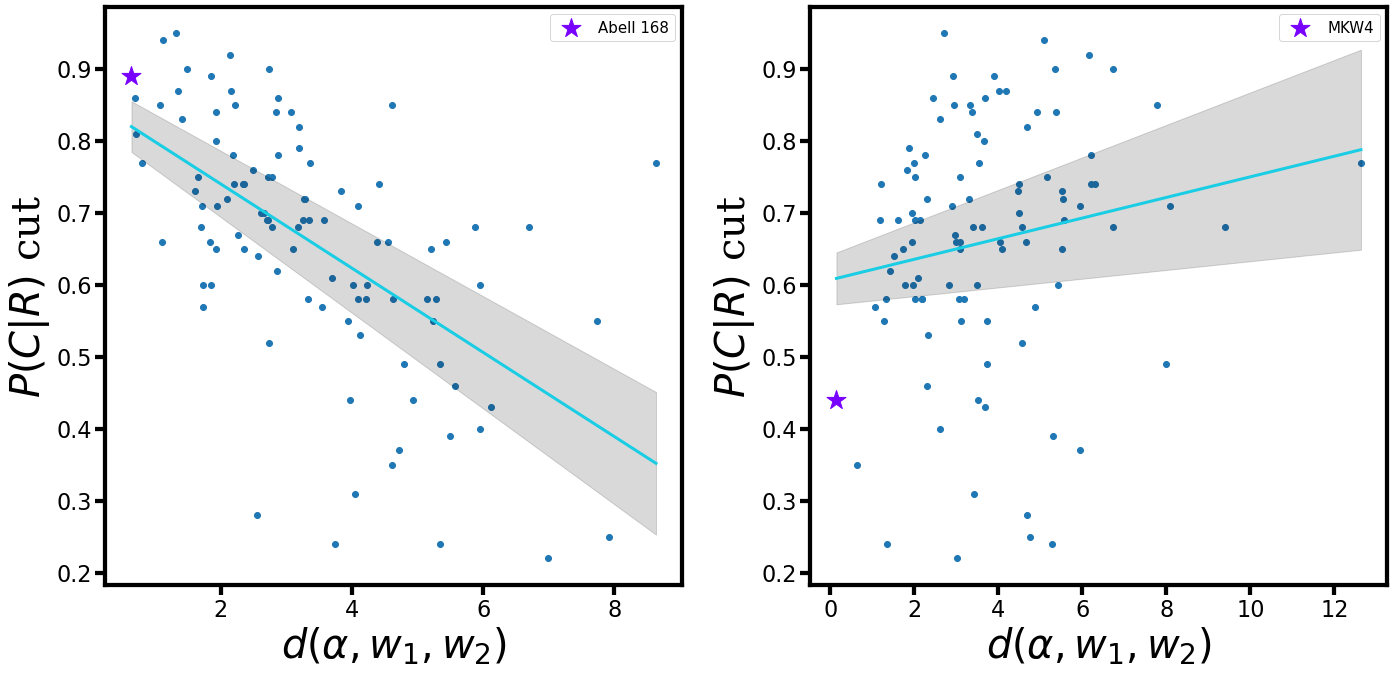

In [8]:
f1 = lambda x, a, b: a*x + b
f2 = lambda x, a, b, c: a*x**2 + b*x + c
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)

x = d_a168
y = cut_R_list[cut_R_list != 0]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax1.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax1.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax1.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax1.set_xlabel(r"$d(\alpha, w_1, w_2)$", fontdict=font)
ax1.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax1.scatter(d_a168[np.argmin(d_a168)], cut_R_list[cut_R_list != 0][np.argmin(d_a168)], label="Abell 168", marker='*', s=400, color=colors3[3])
ax1.legend(fontsize=15)


ax2 = fig.add_subplot(122)

x = d_mkw4
y = cut_R_list[cut_R_list != 0]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax2.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax2.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax2.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax2.set_xlabel(r"$d(\alpha, w_1, w_2)$", fontdict=font)
ax2.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax2.scatter(d_mkw4[np.argmin(d_mkw4)], cut_R_list[cut_R_list != 0][np.argmin(d_mkw4)], label="MKW4", marker='*', s=400, color=colors3[3])
ax2.legend(fontsize=15)


fig.tight_layout(pad=3.0)

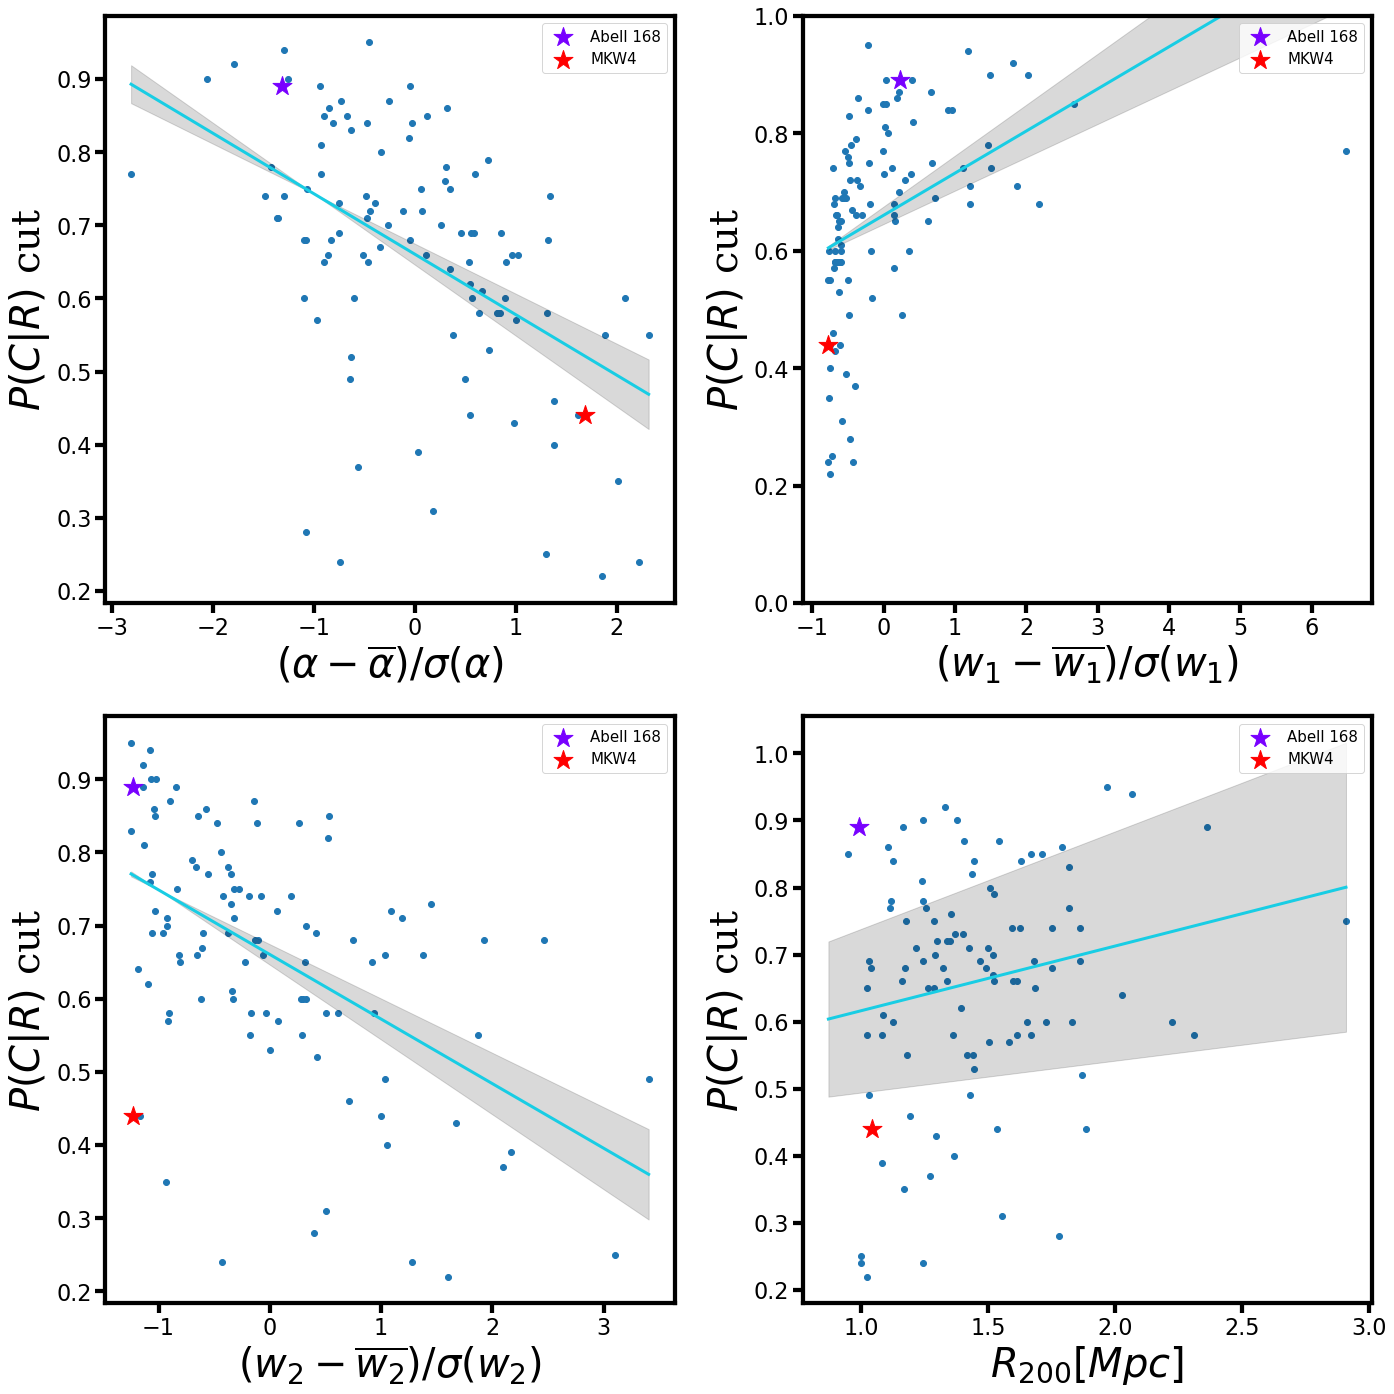

In [11]:
fig = plt.figure(figsize=(20, 20))

#Plot 1
ax1 = fig.add_subplot(221)

x = (alpha_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])] - mean_alpha) / std_alpha
y = cut_R_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax1.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax1.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax1.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax1.set_xlabel(r"$(\alpha - \overline{\alpha})/\sigma(\alpha)$", fontdict=font)
ax1.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax1.scatter((alpha_a168 - mean_alpha)/std_alpha, best_R_cut_a168, label="Abell 168", marker='*', s=400, color=colors3[3])
ax1.scatter((alpha_mkw4 - mean_alpha)/std_alpha, best_R_cut_mkw4, label="MKW4", marker='*', s=400, color=colors2[9])
ax1.legend(fontsize=15)


#Plot 2
ax2 = fig.add_subplot(222)

x = (w1_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])] - mean_w1) / std_w1

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax2.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax2.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax2.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax2.set_xlabel(r"$(w_1 - \overline{w_1}) / \sigma(w_1)$", fontdict=font)
ax2.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax2.scatter((w1_a168 - mean_w1)/std_w1, best_R_cut_a168, label="Abell 168", marker='*', s=400, color=colors3[3])
ax2.scatter((w1_mkw4 - mean_w1)/std_w1, best_R_cut_mkw4, label="MKW4", marker='*', s=400, color=colors2[9])
ax2.legend(fontsize=15)
ax2.set_ylim(0, 1.0)


#Plot 3
ax3 = fig.add_subplot(223)

x = (w2_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])] - mean_w2) / std_w2

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax3.scatter(x, y)

x_new = np.linspace(x.min(), x.max(), 100)
ax3.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax3.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)

ax3.set_xlabel(r"$(w_2 - \overline{w_2})/\sigma(w_2)$", fontdict=font)
ax3.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax3.scatter((w2_a168 - mean_w2) / std_w2, best_R_cut_a168, label="Abell 168", marker='*', s=400, color=colors3[3])
ax3.scatter((w2_mkw4 - mean_w2) / std_w2, best_R_cut_mkw4, label="MKW4", marker='*', s=400, color=colors2[9])
ax3.legend(fontsize=15)


#Plot 4
ax4 = fig.add_subplot(224)

x = r200_mpc_list[cut_R_list != 0][~np.isnan(cut_R_list[cut_R_list != 0])]

popt, cov = curve_fit(f1, x, y)
a, b = popt
sigma = np.sqrt(np.diagonal(cov))

ax4.scatter(x, y)

x_new = np.linspace(0.869956, x.max(), 100)
ax4.plot(x_new, f1(x_new, a, b), '-', lw=3, color=colors2[2])
bound_upper = f1(x_new, *(popt + sigma))
bound_lower = f1(x_new, *(popt - sigma))
# plotting the confidence intervals
ax4.fill_between(x_new, bound_lower, bound_upper, color ='black', alpha=0.15)


ax4.set_xlabel(r"$R_{200} [Mpc]$", fontdict=font)
ax4.set_ylabel(r"$P(C|R)$ cut", fontdict=font)
ax4.scatter(0.989478, best_R_cut_a168, label="Abell 168", marker='*', s=400, color=colors3[3])
ax4.scatter(1.040702, best_R_cut_mkw4, label="MKW4", marker='*', s=400, color=colors2[9])
ax4.legend(fontsize=15)

fig.tight_layout(pad=3.0)

### Distribution of purity, completeness and of the cuts

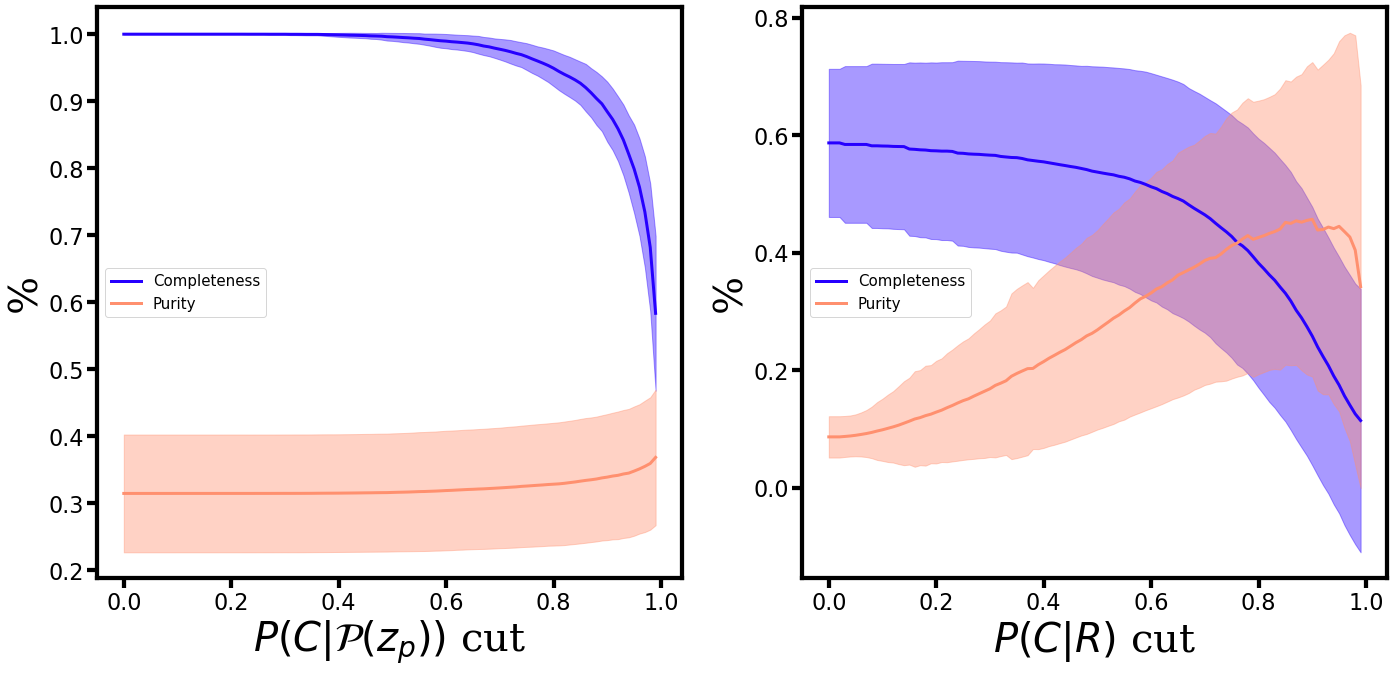

In [31]:
Pmem_cut_arr = np.arange(0.0, 1.0, 0.01)

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
    
mean_c_zps = np.mean(c_zp_list, axis=0)
mean_p_zps = np.mean(p_zp_list, axis=0)
mean_c_Rs = np.mean(c_R_list, axis=0)
mean_p_Rs = np.array([np.mean(p_R_list[:, i][~np.isnan(p_R_list[:, i])], axis=0) for i in range(len(p_R_list[0]))])

sigma_c_zps = np.array([np.sqrt(np.sum((c_zp_list[:, i] - mean_c_zps[i])**2)/len(c_zp_list)) for i in range(len(mean_c_zps))])
sigma_p_zps = np.array([np.sqrt(np.sum((p_zp_list[:, i] - mean_p_zps[i])**2)/len(p_zp_list)) for i in range(len(mean_p_zps))])
sigma_c_Rs = np.array([np.sqrt(np.sum((c_R_list[:, i] - mean_c_Rs[i])**2)/len(c_R_list)) for i in range(len(mean_c_Rs))])
sigma_p_Rs = np.array([np.sqrt(np.sum((p_R_list[:, i][~np.isnan(p_R_list[:, i])] - mean_p_Rs[i])**2)/len(p_R_list[:, i][~np.isnan(p_R_list[:, i])])) for i in range(len(mean_p_Rs)) ])

    
ax1.plot(Pmem_cut_arr, mean_c_zps, color=colors3[2], lw=3, label="Completeness")
ax1.fill_between(Pmem_cut_arr, mean_c_zps-sigma_c_zps, mean_c_zps+sigma_c_zps, color=colors3[2], alpha=0.4)
ax1.plot(Pmem_cut_arr, mean_p_zps, color=colors3[6], lw=3, label="Purity")
ax1.fill_between(Pmem_cut_arr, mean_p_zps-sigma_p_zps, mean_p_zps+sigma_p_zps, color=colors3[6], alpha=0.4)
ax1.legend(fontsize=15, loc=6)
ax1.set_xlabel(r"$P(C|\mathcal{P}(z_p))$ cut", fontdict=font)
ax1.set_ylabel("%", fontdict=font)


ax2.plot(Pmem_cut_arr, mean_c_Rs, color=colors3[2], lw=3, label="Completeness")
ax2.fill_between(Pmem_cut_arr, mean_c_Rs-sigma_c_Rs, mean_c_Rs+sigma_c_Rs, color=colors3[2], alpha=0.4)
ax2.plot(Pmem_cut_arr, mean_p_Rs, color=colors3[6], lw=3, label="Purity")
ax2.fill_between(Pmem_cut_arr, mean_p_Rs-sigma_p_Rs, mean_p_Rs+sigma_p_Rs, color=colors3[6], alpha=0.4)
ax2.legend(fontsize=15, loc=6)
ax2.set_xlabel(r"$P(C|R)$ cut", fontdict=font)
ax2.set_ylabel("%", fontdict=font)

fig.tight_layout(pad=3.0)

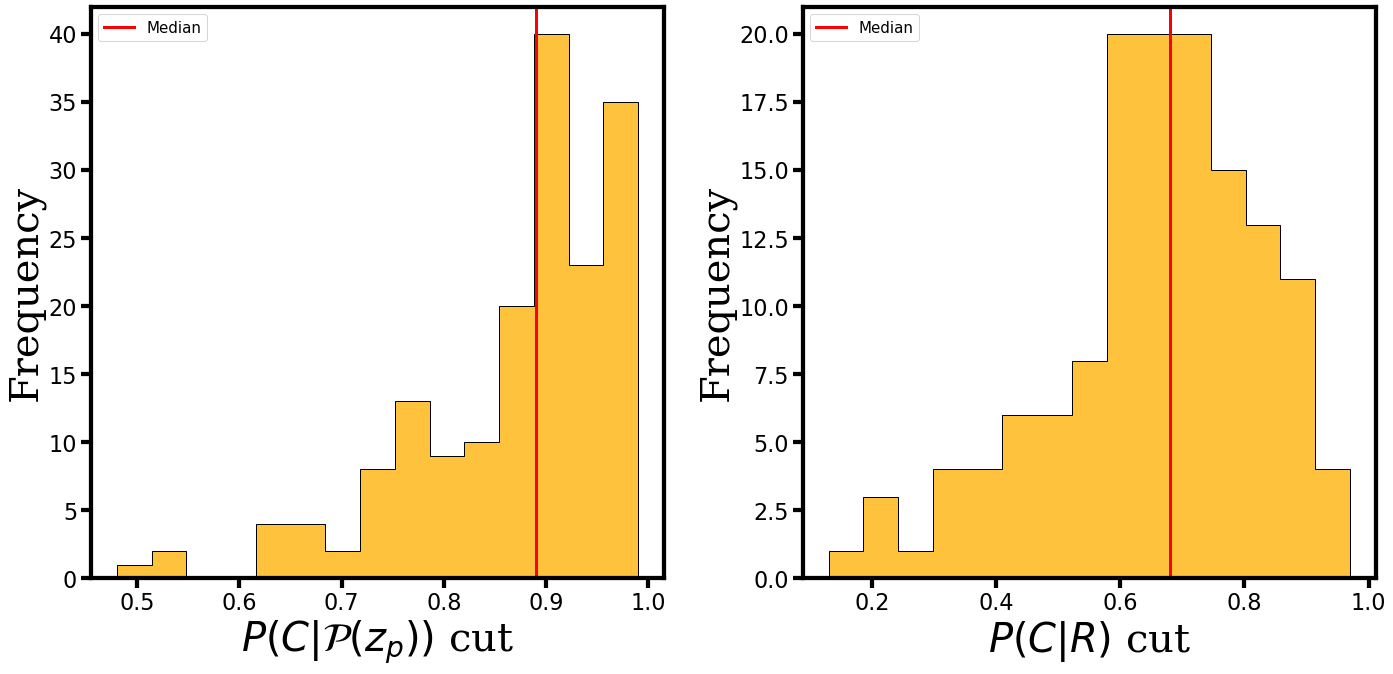

In [6]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(cut_zp_list[cut_zp_list != 0], bins=15, color=colors3[7], histtype='stepfilled', edgecolor='k')[2]
ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel(r"$P(C|\mathcal{P}(z_p))$ cut", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(cut_R_list[cut_R_list != 0], bins=15, color=colors3[7], histtype='stepfilled', edgecolor='k')[2]
ax2.axvline(cut_R_median, color="red", lw=3, label="Median")
ax2.set_xlabel(r"$P(C|R)$ cut", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
ax2.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

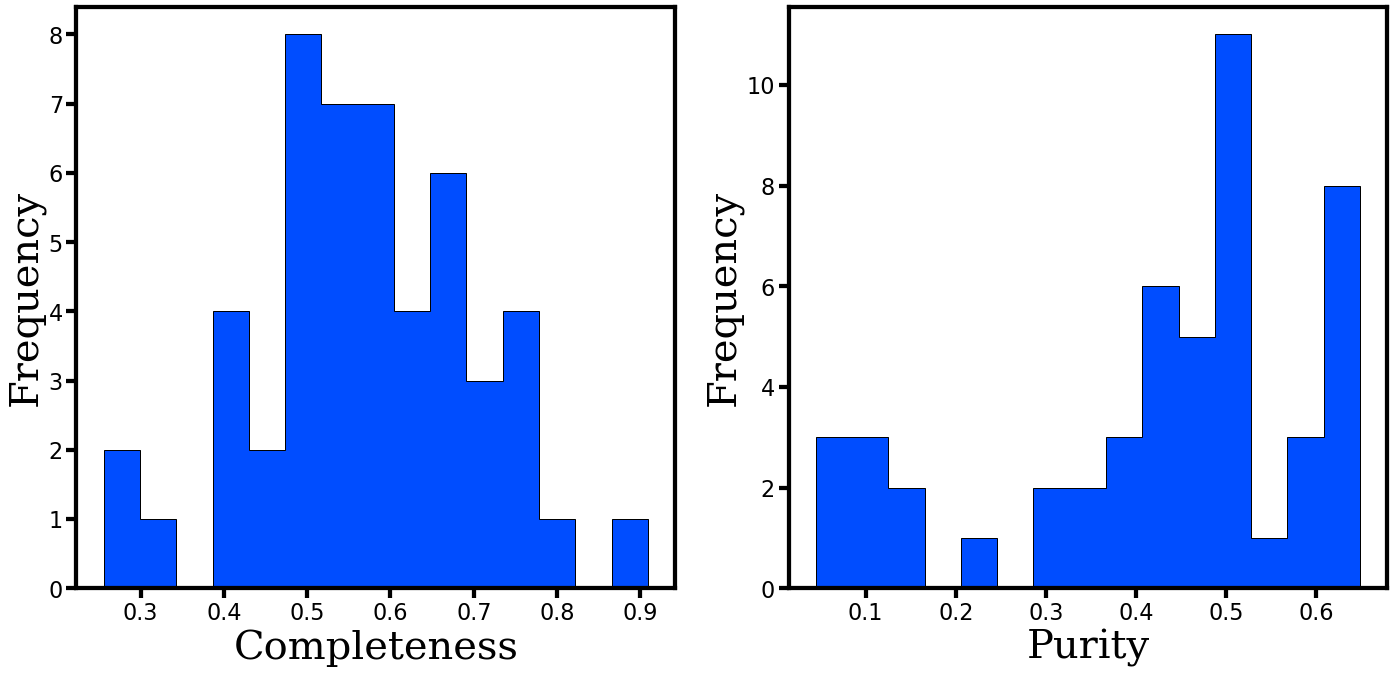

In [11]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(c_R_max_list, bins=15, color=colors1[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel("Completeness", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(p_R_max_list, bins=15, color=colors1[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax2.set_xlabel("Purity", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

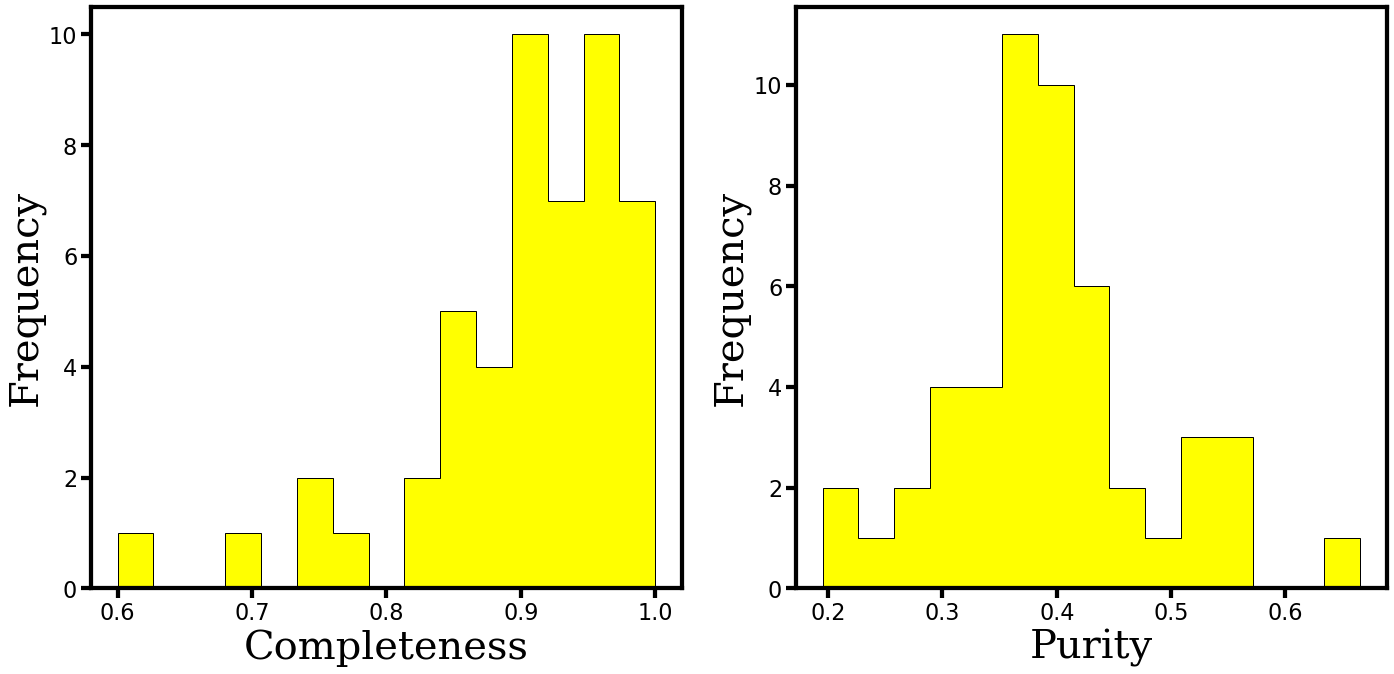

In [12]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(c_zp_max_list, bins=15, color="yellow", histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel("Completeness", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)

ax2 = fig.add_subplot(122)
ax2.hist(p_zp_max_list, bins=15, color="yellow", histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax2.set_xlabel("Purity", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)


fig.tight_layout(pad=3.0)

## Distribution of properties of the mock clusters

In [22]:
hdul = fits.open("cluster-mocks/lightcone_zphot_subhalos_AllFrom1.fits")
scat = hdul[1].data

magr = scat["mag_r"]
mask_mag = magr < 21

haloId = scat["haloId"][mask_mag]
galaxyId = scat["galaxyId"][mask_mag]
z_phot_original = scat["z_phot"][mask_mag]
z_spec = scat["z_app"][mask_mag]
ra = scat["RA"][mask_mag]
dec = scat["DEC"][mask_mag]
magr = scat["mag_r"][mask_mag]
magu = scat["mag_u"][mask_mag]
magg = scat["mag_g"][mask_mag]
magi = scat["mag_i"][mask_mag]
magz = scat["mag_z"][mask_mag]
firstHaloinFoFGroupId = scat["firstHaloinFoFGroupId"][mask_mag]

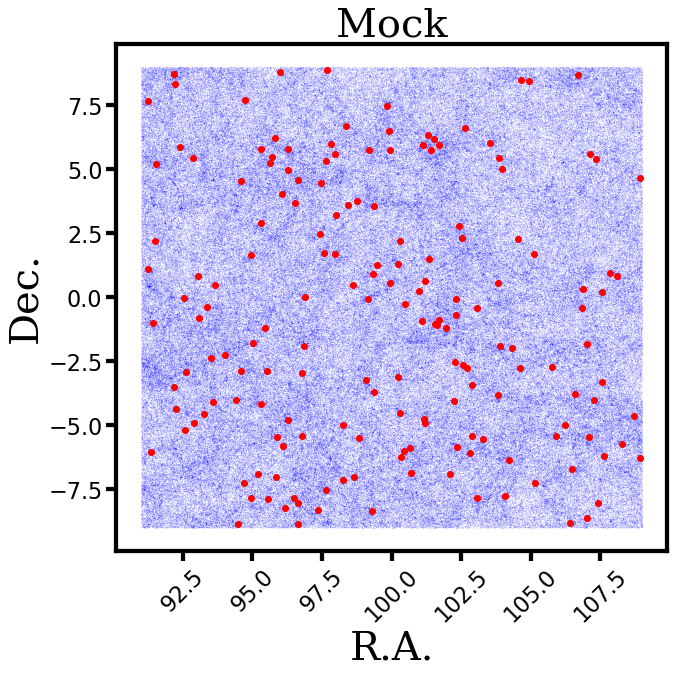

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

sc = ax.scatter(ra, dec, c="blue", s=0.0005)
ax.scatter(ra0_list, dec0_list, marker='o', color='red')
ax.set_xlabel("R.A.", fontdict=font)
ax.set_ylabel("Dec.", fontdict=font)
ax.set_title("Mock", fontdict=font)

ax.tick_params(axis='x', rotation=45)
    
fig.tight_layout(pad=3.0)

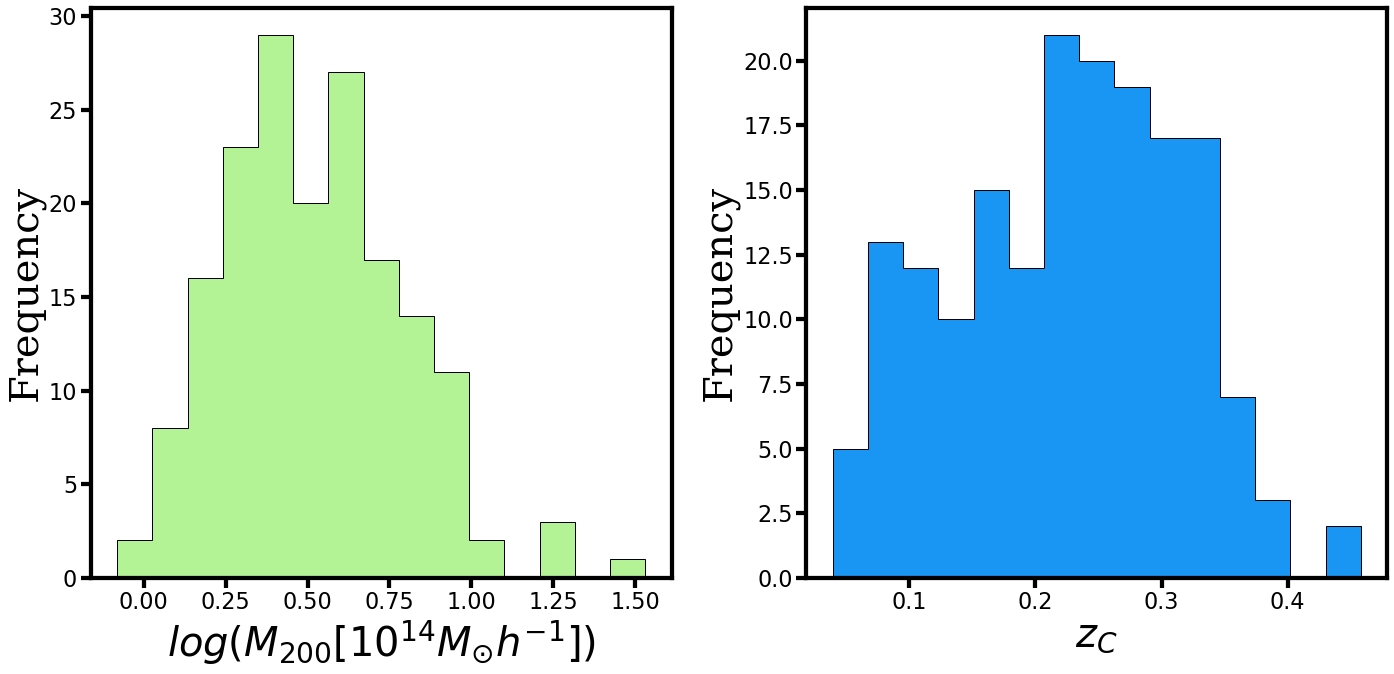

In [5]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(np.log10(m200_list/1e14), bins=15, color=colors2[5], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax1.set_xlabel(r"$log(M_{200} [ 10^{14} M_{\odot} h^{-1}])$", fontdict=font)
ax1.set_ylabel("Frequency", fontdict=font)
# ax1.set_xscale("log")
# ax1.legend(fontsize=15, loc=2)


ax2.hist(z_cluster_list, bins=15, color=colors2[1], histtype='stepfilled', edgecolor='k')[2]
# ax1.axvline(cut_zp_median, color="red", lw=3, label="Median")
ax2.set_xlabel(r"$z_C$", fontdict=font)
ax2.set_ylabel("Frequency", fontdict=font)
# ax1.legend(fontsize=15, loc=2)

fig.tight_layout(pad=3.0)